In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt

import mala

In [2]:
dim = 2
h = 0.1
n = 2000
N_train = 100
N_test = 100

def f(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return 1/2 * (np.linalg.norm(x-a)**2) - np.log(1 + np.exp(-2 * x.T @ a))

def f_grad(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return x - a + 2 * a/(1 + np.exp(2* (x.T @ a)))

def pi(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return 1/(2 * (2 * np.pi)**(dim/2)) * (np.exp(-np.linalg.norm(x-a)**2 /2) + np.exp(-np.linalg.norm(x+a)**2 / 2))


def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

# t = np.arange(-5, 5, 0.1)
# s = np.array(list(map(pi, t)))

# plt.plot(t, s)
# plt.show()

In [3]:
def ULA_with_burnin(d, step, burn_in, n, f_grad):
    """ MCMC ULA
    Args:
        Md: dimension
        step: stepsize of the algorithm
        burn_in: burn-in period
        n: number of samples after the burn-in
        f_grad: gradient of the potential U
    Returns:
        traj: a numpy array of size (n, d), where the trajectory is stored
        traj_grad: numpy array of size (n, d), where the gradients of the potential U along the trajectory are stored
        traj_noise: numpy array of size (n, d), where the noises along trajectory are stored
    """
    traj = np.zeros((burn_in + n, d))
    traj_grad = np.zeros((burn_in + n, d))
    traj_noise = np.random.randn(burn_in + n, d)
    
    traj[0] = (np.random.normal(0,1,d)).reshape(d)
    traj_grad[0] = f_grad(traj[0])

    for i in range(1,burn_in + n):
        traj[i] = traj[i-1] - step/2*traj_grad[i-1] + np.sqrt(step) * traj_noise[i]
        traj_grad[i] = f_grad(traj[i])
    return traj[burn_in:], traj_grad[burn_in:], traj_noise[burn_in:]

In [4]:
np.random.seed(42)
X_ULA, _, _  = ULA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad)
X, G, Z , U, ac_rate = mala.MALA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad, f = f)

0.99487


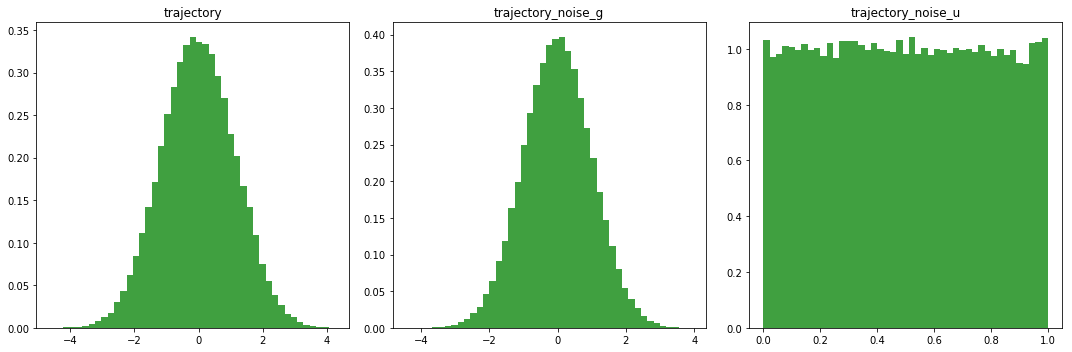

In [6]:
print (ac_rate)
mala.plot_distr(X, Z, U, 0)

In [7]:
np.random.seed(123)

XX, GG, ZZ, UU = mala.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad, f = f)
XX_test, GG_test, ZZ_test, UU_test = mala.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad, f = f)

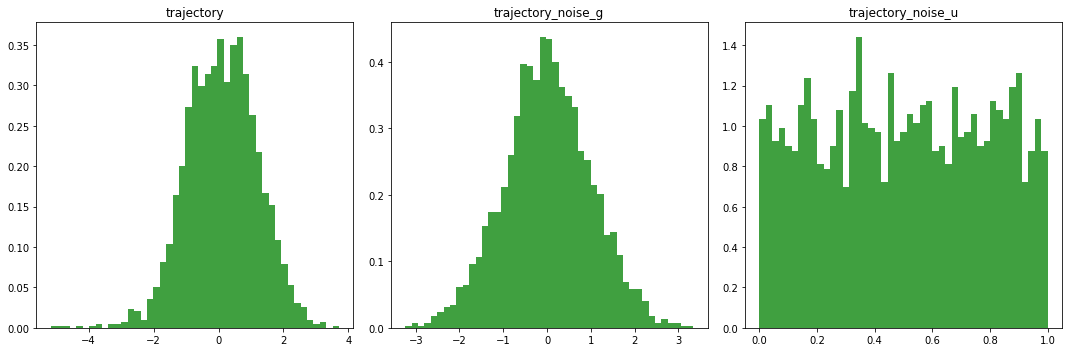

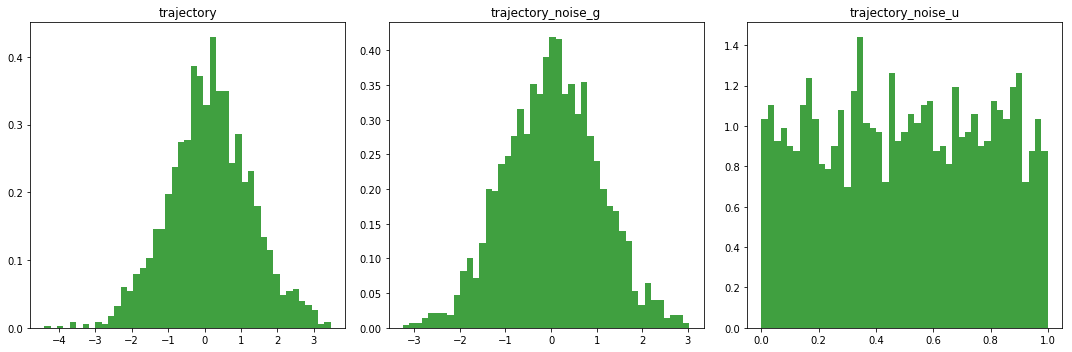

In [8]:
mala.plot_distr(XX[5], ZZ[5], UU[5], 0)
mala.plot_distr(XX[5], ZZ[5], UU[5], 1)

In [9]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h

def L(k,x):
    if k==0:
        return 1.
    elif k==1:
        return np.sqrt(3) * (2*x - 1)
    elif k ==2:
        return np.sqrt(5) * (6*x**2 - 6*x +1)
    else:
        return None
    
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

def phi_val(k_vec, x_vec, k, uni):
    return Hermite_val(k_vec, x_vec) * L(k, uni)

In [17]:
k_comb = np.zeros((dim,dim), dtype=np.int16)
for i in range(dim):
    k_comb[i,i] = 1